In [1]:
import sys
sys.path.append("..") 
import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm
from mizani.formatters import date_format
from utils import generate_15min_intervals

## Collect data

In [2]:
# Collect train data
train_df = pd.read_csv('../train.csv')
# Add addtl fields
train_df['interval_et'] = pd.to_datetime(train_df['interval_et'])
train_df['interval_et_date'] = train_df['interval_et'].dt.date
train_df['interval_et_time'] = train_df['interval_et'].dt.strftime('%H:%M:%S')
train_df['interval_et_dayofweek'] = train_df['interval_et'].dt.day_name()

/var/folders/mq/648wjp012j9_wnylgmqg_zcc0000gn/T/ipykernel_39796/2975110445.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


In [3]:
# Collect test data
test_df = pd.read_csv('../test.csv')
# Add addtl fields
test_df['interval_et'] = pd.to_datetime(test_df['interval_et'])
test_df['interval_et_date'] = test_df['interval_et'].dt.date
test_df['interval_et_time'] = test_df['interval_et'].dt.strftime('%H:%M:%S')
test_df['interval_et_dayofweek'] = test_df['interval_et'].dt.day_name()

/var/folders/mq/648wjp012j9_wnylgmqg_zcc0000gn/T/ipykernel_39796/1373536567.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


## EDA

#### Days of week
- Takeaways:
    - Almost all of this data are for week days. Given the amount/context of historical data on weekends, I'm not going to attempt to make predictions on weekends using this data and therefore not train on weekend data. I would check with business stakeholders before actually doing this.

In [4]:
# number of chats on each day in train data
train_df.groupby('interval_et_dayofweek')['interval_et_date'].count()

interval_et_dayofweek
Friday       6094
Monday       5845
Saturday        4
Sunday          6
Thursday     6769
Tuesday      6946
Wednesday    6949
Name: interval_et_date, dtype: int64

#### Missingness
- Takeaways:
    - Not all days have the same number of timestamps (every 15 minutes). It looks like 15 minutes blocks with no chats are not included here. **I'm going to assume that is the case**
    - The question then becomes which the hours in each weekday are we interested in making predictions for? Most chats appear to happen between 04:00 and 16:45, however there are a few outside of that. So it does appear we can handle chats outside of those hours, but the vast marjority of the time that won't happen. I'm going to assume we want to make predictions for any 15 minute interval in any hour, on a given weekday. I created `utils.generate_15min_intervals()` to help me do this.

In [5]:
# number of chat intervals in each day in train data
train_df.groupby('interval_et_date')['interval_et'].count()

interval_et_date
2020-01-02    35
2020-01-03    31
2020-01-06    35
2020-01-07    35
2020-01-08    38
              ..
2022-09-26    52
2022-09-27    52
2022-09-28    53
2022-09-29    52
2022-09-30    52
Name: interval_et, Length: 697, dtype: int64

In [6]:
# number of chat intervals in each day in test data
test_df.groupby('interval_et_date')['interval_et'].count()

interval_et_date
2022-10-03    52
2022-10-04    52
2022-10-05    53
2022-10-06    53
2022-10-07    52
              ..
2022-12-23    52
2022-12-27    32
2022-12-28    52
2022-12-29    52
2022-12-30    52
Name: interval_et, Length: 64, dtype: int64

In [7]:
# distribution of first chat times of the day in test data
test_df\
    .groupby('interval_et_date')['interval_et_time'].agg(['min','max'])\
    .reset_index()\
    .groupby(['min'])['interval_et_date'].nunique()\
    .reset_index()\
    .sort_values(by=['interval_et_date'], ascending=False)

,min,interval_et_date
4,04:00:00,48
3,03:45:00,6
7,05:00:00,4
0,01:30:00,1
1,03:15:00,1
2,03:30:00,1
5,04:15:00,1
6,04:30:00,1
8,09:00:00,1


In [8]:
# distribution of last chat times of the day in test data
test_df\
    .groupby('interval_et_date')['interval_et_time'].agg(['min','max'])\
    .reset_index()\
    .groupby(['max'])['interval_et_date'].nunique()\
    .reset_index()\
    .sort_values(by=['interval_et_date'], ascending=False)

,max,interval_et_date
3,16:45:00,55
4,17:15:00,2
0,01:30:00,1
1,11:00:00,1
2,11:15:00,1
5,17:30:00,1
6,19:15:00,1
7,19:30:00,1
8,19:45:00,1


In [9]:
# Create all 15 minute timestamps across the training period
train_date_base_df = generate_15min_intervals(
    str(train_df['interval_et_date'].min()),
    str(train_df['interval_et_date'].max())
)
# Join train data and impute missing values as zero (assumes no chats happened and that's why its not in train data)
train_df = train_date_base_df.merge(train_df, on='interval_et', how='left')
train_df['chats'] = train_df['chats'].fillna(int(0))

#### Visualization
- Takeaways:
   - I decomposed the train chats below. Note that the y-axes (chats) varies across components.
   - Positive trend across time in chats.
   - Chats appear to drop off near the end of the year (holidays?). There is also one large decrease in April 2022.
   - There appears to be weak, if any, weekly seasonality.
   - After taking the seasons and trends into account, there doesn't appear to be any pattern in the residuals, which is what we're looking for. It looks like there could be a slight uptick in variation of residuals starting in March 2022. I would get further buisness context to confirm/deny why that may happen (e.g. product change?)

Modeling decision:
 - Given what I'm seeing in this notebook (seasonal effects with lots of data), the fact that there are no exgonenous predictors, and a single series to estimate, I will use the `Prophet` package as a procedure for fitting and predicting with a model.
 - It most likely will be helpful to `log(chats)` to generate non-negative predictions
 - With so many assumed zeroes, percentage based evaluation metrics like `MAPE` aren't the best to use.

/Users/noah/opt/anaconda3/envs/kt/lib/python3.9/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/noah/opt/anaconda3/envs/kt/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 336 rows containing missing values.
/Users/noah/opt/anaconda3/envs/kt/lib/python3.9/site-packages/plotnine/geoms/geom.py:289: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


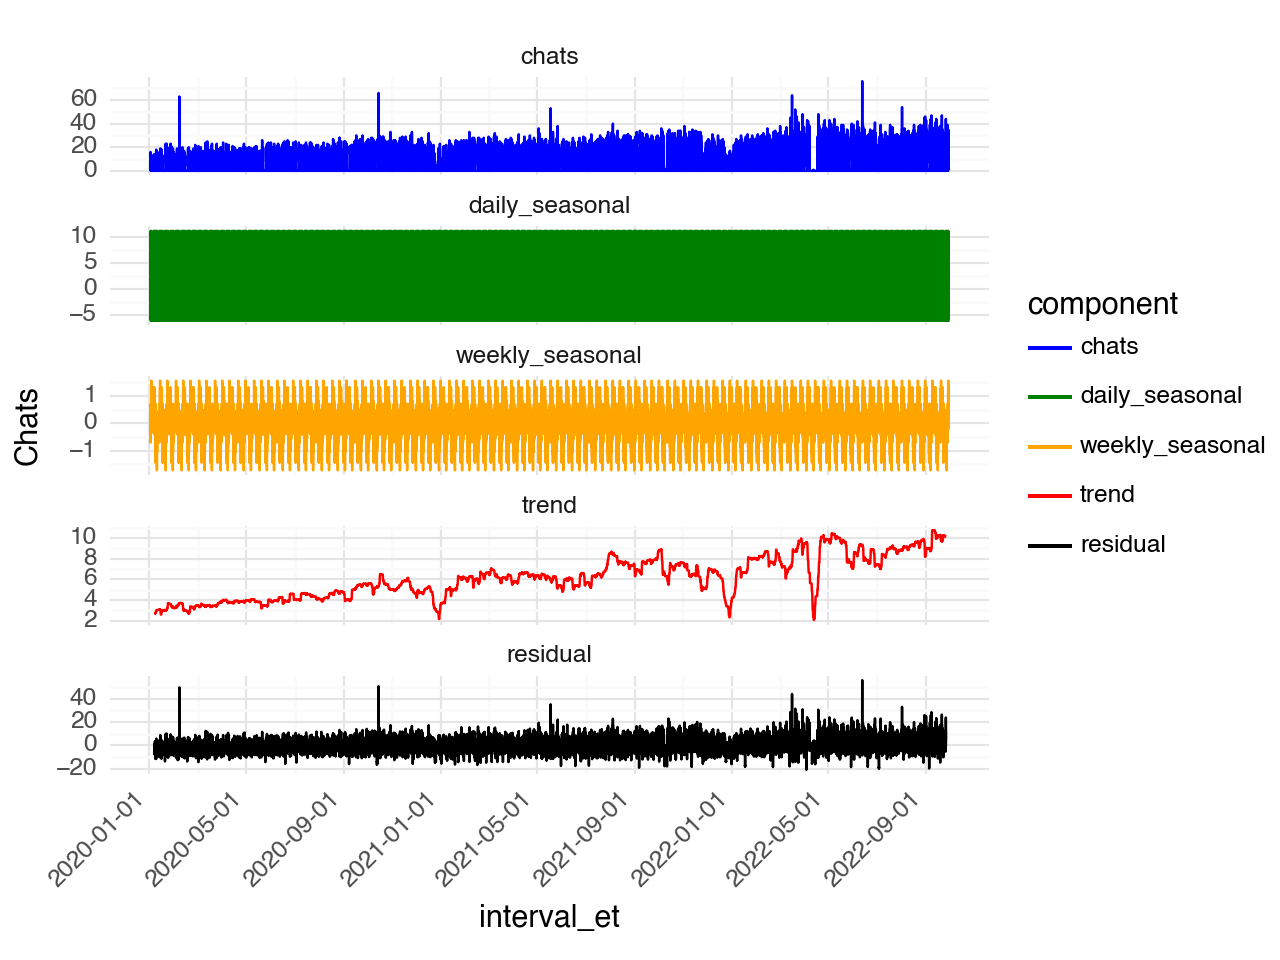

In [10]:
# First Decomposition for Daily Seasonality (15 min data)

decomp_daily = sm.tsa.seasonal_decompose(train_df['chats'], model='additive', period=4*24)
train_df['daily_seasonal'] = decomp_daily.seasonal

# Remove Daily Seasonality
train_df['chats_adjusted'] = train_df['chats'] - train_df['daily_seasonal']

# Second Decomposition for Weekly Seasonality (15 min data)
decomp_weekly = sm.tsa.seasonal_decompose(train_df['chats_adjusted'], model='additive', period=4*24*7)
train_df['weekly_seasonal'] = decomp_weekly.seasonal
train_df['trend'] = decomp_weekly.trend
train_df['residual'] = decomp_weekly.resid

# Prepare DataFrame for Plotnine
component_order = ['chats', 'daily_seasonal', 'weekly_seasonal', 'trend', 'residual']
plot_df = train_df.reset_index().melt(id_vars=['interval_et'], 
                                value_vars=component_order,
                                var_name='component', value_name='value')
plot_df['component'] = pd.Categorical(plot_df['component'], categories=component_order, ordered=True)

# Plot using Plotnine
custom_colors = {
    'chats': 'blue',
    'daily_seasonal': 'green',
    'weekly_seasonal': 'orange',
    'trend': 'red',
    'residual': 'black'
}
plot = (ggplot(plot_df, aes(x='interval_et', y='value', color='component'))
        + geom_line()
        + facet_wrap('~component', scales='free_y', ncol=1)
        + scale_color_manual(values=custom_colors)
        + theme_minimal()
        + theme(axis_text_x=element_text(rotation=45, hjust=1))
        + labs(x='interval_et', y='Chats')
)
print(plot)